# EWAS XGboost EDA1 (500 samples, whole blood, healthy, p450)


### This notebook reads in a dataframe named 'df_processed' from a file that is produced by the notebook named 'Read_EWAS_DATA'. It then:
* Runs and Xboost regresser on age with all features (195,948)
* Plots real vs predicted age
* Identifies the top 100 most import cpg features
* Runs and Xboost regresser on age with only the top 100 most important features
* Runs a linear regression analysis with just those top 100 cpgs
* Runs a linear regression analysis with the full 200,000 cpgs
* Creates PCA plots for all the data, and just the top 100 cpgs
* Runs linear regression models on the top 100 cpgs separately for each sex

### Conclusions

* Using the whole dataset (195,948 CpGs with no NaNs, EWAS 500 samples) a default XGBoost model can predict age on test data to within a rms of ~7 years.

* A linear regression model can do as well or better (rms 5.6 years)

* The XGBoost can be used to select the top 100 most important CpG features out of the ~200,000.

* Linear models or XGboost models work just as well using this subset of 100 features as they do with the full 200,000

* PCA Analysis of the full dataset indicates a strong segregation by sex

* PCA Anlysis on just the top 100 CpGs, shows segregation by age and sex

* It may be a good idea to treated the sexes separately, or remove X and Y chromosome CpGs

* Separating the sexes did not improve the linear models




In [ ]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [ ]:
%%time
# Read in dataframe, with 500 samples this takes ~ 6 min
df_processed = pd.read_csv('df_processed.csv', index_col=0)

In [130]:
df_processed

,age,sex,tissue,platform,project,cg02494853,cg03706273,cg05213048,cg15295597,cg27539833,...,cg27665648,ch.22.17803970R,ch.22.107403R,ch.22.22597277R,ch.22.427671F,ch.22.467397R,ch.22.33863861F,ch.22.38010425R,ch.22.43177094F,ch.22.46830341F
sample_GSM1069224,84.0,F,whole blood,450K,GSE43414,0.014,0.011,0.718,0.016,0.854,...,0.898,0.135,0.001,0.001,0.002,0.001,0.009,0.005,0.000,0.002
sample_GSM1069230,82.0,F,whole blood,450K,GSE43414,0.021,0.098,0.851,0.041,0.912,...,0.893,0.146,0.001,0.001,0.002,0.001,0.016,0.003,0.000,0.003
sample_GSM1069231,80.0,F,whole blood,450K,GSE43414,0.031,0.078,0.608,0.034,0.928,...,0.911,0.097,0.002,0.002,0.002,0.002,0.015,0.004,0.000,0.003
sample_GSM1069233,88.0,M,whole blood,450K,GSE43414,0.032,0.057,0.829,0.043,0.934,...,0.888,0.122,0.002,0.001,0.002,0.002,0.014,0.004,0.000,0.003
sample_GSM1069234,74.0,F,whole blood,450K,GSE43414,0.013,0.047,0.576,0.023,0.931,...,0.927,0.117,0.001,0.001,0.002,0.001,0.019,0.004,0.000,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1302014,31.0,M,whole blood,450K,GSE53841,0.024,0.020,0.698,0.021,0.964,...,0.845,0.131,0.002,0.005,0.009,0.002,0.028,0.010,0.006,0.005
sample_GSM1320504,57.0,M,whole blood,450K,GSE54643,0.031,0.025,0.788,0.025,0.947,...,0.868,0.132,0.002,0.001,0.004,0.002,0.030,0.006,0.000,0.003
sample_GSM1320505,57.0,M,whole blood,450K,GSE54643,0.036,0.034,0.785,0.037,0.932,...,0.881,0.127,0.002,0.003,0.005,0.002,0.028,0.009,0.000,0.004
sample_GSM1320506,48.0,M,whole blood,450K,GSE54643,0.025,0.031,0.699,0.033,0.932,...,0.914,0.147,0.002,0.003,0.005,0.002,0.031,0.008,0.001,0.003


### Running an XGBoost regression model on all the data to predict age

In [38]:
# Split data 80 / 20
from sklearn.model_selection import train_test_split
X = df_processed.iloc[:,5:]
y = df_processed.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [39]:
%%time
# import an X gradient boost object and train it, wiuth 500 samples takes 1.5 min
from xgboost import XGBRegressor
XG = XGBRegressor(objective='reg:squarederror')
XG.fit(X_train, y_train)
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(XG, X_train, y_train, scoring='neg_mean_squared_error')
#(-scores)**0.5

CPU times: user 8min 2s, sys: 1.24 s, total: 8min 4s
Wall time: 1min 27s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(XG, X_train, y_train, scoring='neg_mean_squared_error')
# (-scores)**0.5

In [41]:
# Get predictions for the model on the training set and the test set.
preds_train = XG.predict(X_train)
preds_test = XG.predict(X_test)

In [42]:
# Assessing fit, calcualting rms for the train and test data
from sklearn.metrics import mean_squared_error
rms_train = (mean_squared_error(y_train, preds_train))**0.5
rms_test = (mean_squared_error(y_test, preds_test))**0.5
print(f'The XGboost rms on the training data is {rms_train} years')
print(f'The XGboost rms on the testing data is {rms_test} years')

The XGboost rms on the training data is 0.0002226944760303295 years
The XGboost rms on the testing data is 8.370217592307887 years


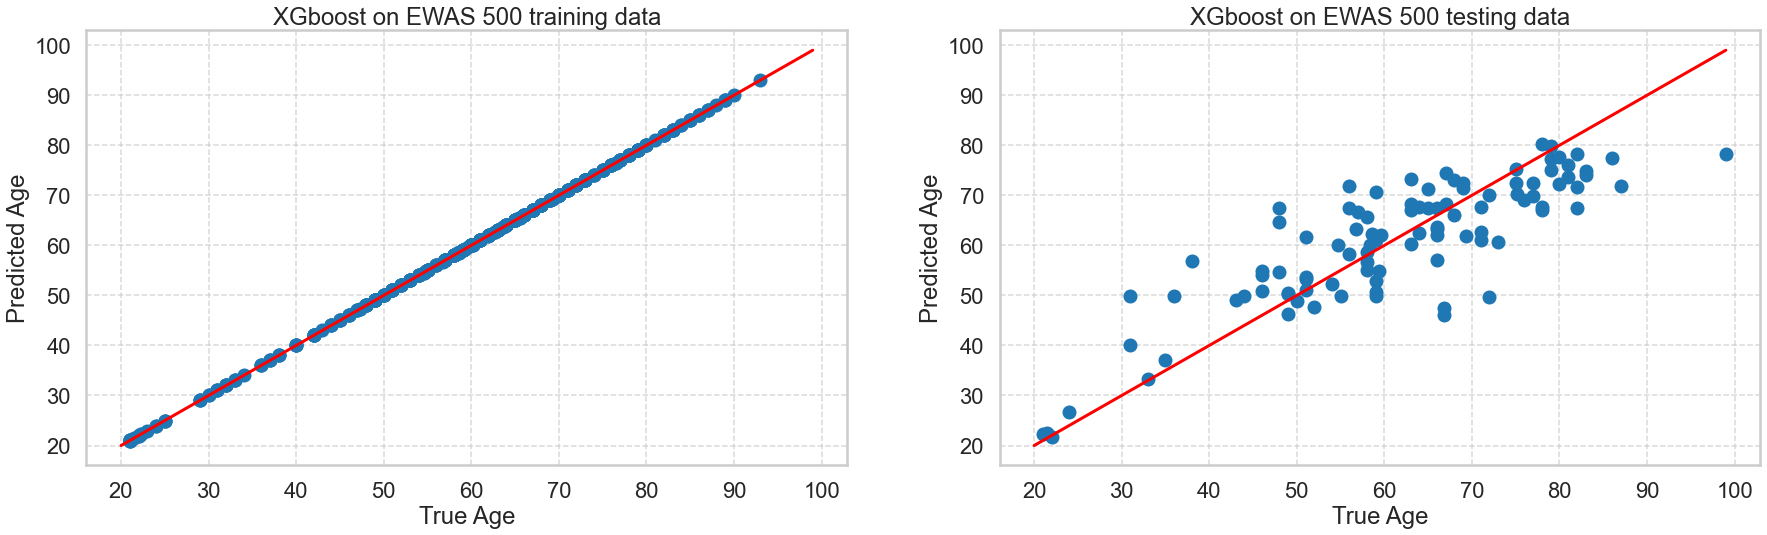

In [43]:
# Making figure of XGboost predicted age vs true age for train and test
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].scatter(y_train, preds_train)
ax[0].plot(range(20,100), range(20,100), c='red')
ax[0].set_xlabel('True Age')
ax[0].set_ylabel('Predicted Age')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].set_title('XGboost on EWAS 500 training data')
ax[1].scatter(y_test, preds_test)
ax[1].plot(range(20,100), range(20,100), c='red')
ax[1].set_xlabel('True Age')
ax[1].set_ylabel('Predicted Age')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].set_title('XGboost on EWAS 500 testing data')
plt.show()

In [44]:
# Calculating r-squared on the train and test data
from sklearn.metrics import r2_score
r2_train = r2_score(y_train, preds_train)
r2_test = r2_score(y_test, preds_test)
print(f'The XGboost r^2 on the training data is {r2_train}')
print(f'The XGboost r^2 on the testing data is {r2_test}')

The XGboost r^2 on the training data is 0.9999999998030029
The XGboost r^2 on the testing data is 0.7154565105888585


In [45]:
# Making a dataframe with CpG names and importance scores ordered highest to lowest
df_importance  = pd.DataFrame({'CpG':df_processed.columns[5:], 'Importance Score':XG.feature_importances_})
df_importance_sorted  = df_importance.sort_values('Importance Score', ascending=False)
df_importance_sorted 

,CpG,Importance Score
68646,cg00614832,0.159145
15948,cg24203960,0.120014
32753,cg16867657,0.105781
20426,cg23435594,0.069728
35050,cg27474149,0.055386
...,...,...
65623,cg27084303,0.000000
65624,cg27086024,0.000000
65625,cg27089768,0.000000
65626,cg27097962,0.000000


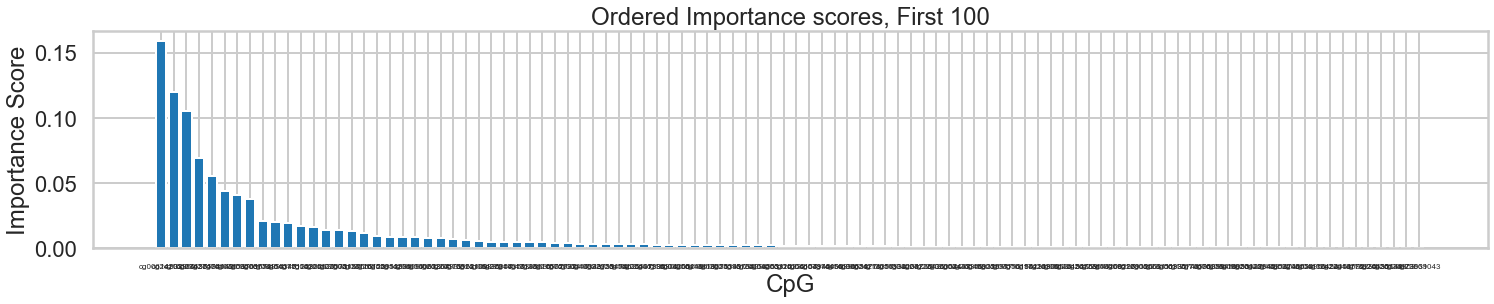

In [71]:
# Plotting the first 100 importance scores
plt.figure(figsize = (25, 4))
plt.title('Ordered Importance scores, First 100')
plt.bar(df_importance_sorted['CpG'][:100], df_importance_sorted['Importance Score'][:100] )
plt.ylabel('Importance Score')
plt.xlabel('CpG')
plt.xticks(fontsize = 8)
plt.show()

In [72]:
# Adding an age column
df_top100 = df_processed[df_importance_sorted['CpG'][:100]]
df_top100.insert(0, "age", df_processed.age)
df_top100

,age,cg00614832,cg24203960,cg16867657,cg23435594,cg27474149,cg05062612,cg07553761,cg09809672,cg06784991,...,cg02059950,cg04130484,cg12422450,cg22044892,cg13775295,cg13920435,cg24550149,cg25534953,cg20973931,cg23669043
sample_GSM1069224,84.0,0.215,0.682,0.766,0.444,0.834,0.039,0.454,0.323,0.325,...,0.993,0.598,0.153,0.853,0.691,0.038,0.958,0.437,0.114,0.104
sample_GSM1069230,82.0,0.194,0.686,0.765,0.539,0.870,0.066,0.299,0.442,0.311,...,0.973,0.602,0.152,0.825,0.628,0.039,0.925,0.400,0.224,0.141
sample_GSM1069231,80.0,0.203,0.701,0.769,0.558,0.869,0.044,0.334,0.408,0.319,...,0.991,0.531,0.134,0.780,0.686,0.067,0.880,0.458,0.192,0.126
sample_GSM1069233,88.0,0.200,0.647,0.771,0.491,0.727,0.035,0.301,0.347,0.274,...,0.986,0.584,0.135,0.883,0.797,0.035,0.923,0.444,0.191,0.085
sample_GSM1069234,74.0,0.220,0.707,0.792,0.567,0.857,0.036,0.301,0.383,0.294,...,0.989,0.584,0.078,0.588,0.856,0.041,0.651,0.292,0.264,0.037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1302014,31.0,0.169,0.800,0.468,0.668,0.891,0.050,0.239,0.513,0.374,...,0.970,0.623,0.042,0.736,0.659,0.064,0.793,0.448,0.304,0.319
sample_GSM1320504,57.0,0.166,0.713,0.669,0.594,0.871,0.036,0.219,0.567,0.246,...,0.991,0.602,0.065,0.808,0.829,0.054,0.842,0.491,0.225,0.210
sample_GSM1320505,57.0,0.224,0.715,0.631,0.574,0.897,0.039,0.210,0.584,0.259,...,0.989,0.579,0.058,0.811,0.849,0.059,0.871,0.453,0.233,0.207
sample_GSM1320506,48.0,0.172,0.698,0.631,0.564,0.857,0.049,0.255,0.509,0.260,...,0.979,0.560,0.127,0.828,0.841,0.045,0.848,0.492,0.234,0.282


### Running an XGBoost regression model with just the top 100 most important CpGs  to predict age

In [75]:
# Split data 80 / 20
X2 = df_top100.iloc[:,1:]
y2 = df_top100.age
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20)

In [76]:
%%time
# import an X gradient boost object and train it, wiuth 500 samples takes 1.5 min
from xgboost import XGBRegressor
XG2 = XGBRegressor(objective='reg:squarederror')
XG2.fit(X_train2, y_train2)
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(XG, X_train, y_train, scoring='neg_mean_squared_error')
#(-scores)**0.5

CPU times: user 723 ms, sys: 20.4 ms, total: 743 ms
Wall time: 150 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XG2, X_train2, y_train2, scoring='neg_mean_squared_error')
(-scores)**0.5

array([7.16803774, 7.24395608, 6.59854134, 6.11434995, 5.81272042])

In [80]:
# Get predictions for the model on the training set and the test set.
preds_train2 = XG2.predict(X_train2)
preds_test2 = XG2.predict(X_test2)

In [81]:
# Assessing fit, calcualting rms for the train and test data
rms_train2 = (mean_squared_error(y_train2, preds_train2))**0.5
rms_test2 = (mean_squared_error(y_test2, preds_test2))**0.5
print(f'The XGboost rms on the training data is {rms_train2} years')
print(f'The XGboost rms on the testing data is {rms_test2} years')

The XGboost rms on the training data is 0.0004366968101325224 years
The XGboost rms on the testing data is 5.879215951662431 years


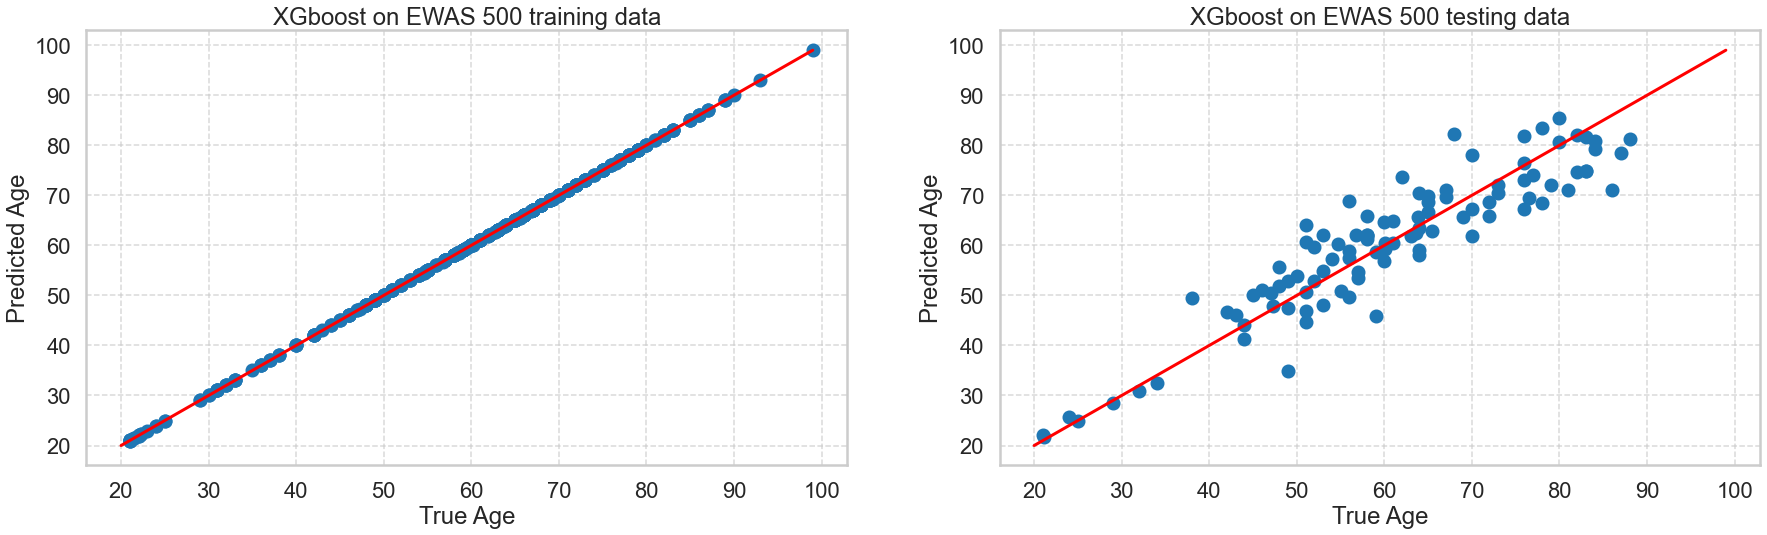

In [82]:
# Making figure of XGboost predicted age vs true age for train and test
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].scatter(y_train2, preds_train2)
ax[0].plot(range(20,100), range(20,100), c='red')
ax[0].set_xlabel('True Age')
ax[0].set_ylabel('Predicted Age')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].set_title('XGboost on EWAS 500 training data')
ax[1].scatter(y_test2, preds_test2)
ax[1].plot(range(20,100), range(20,100), c='red')
ax[1].set_xlabel('True Age')
ax[1].set_ylabel('Predicted Age')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].set_title('XGboost on EWAS 500 testing data')
plt.show()

In [83]:
# Calculating r-squared on the train and test data
from sklearn.metrics import r2_score
r2_train2 = r2_score(y_train2, preds_train2)
r2_test2 = r2_score(y_test2, preds_test2)
print(f'The XGboost r^2 on the training data is {r2_train2}')
print(f'The XGboost r^2 on the testing data is {r2_test2}')

The XGboost r^2 on the training data is 0.999999999255587
The XGboost r^2 on the testing data is 0.850167091060104


### Running linear regression with the top 100 most important CpGs

In [85]:
from sklearn.linear_model import LinearRegression
X3 = df_top100.iloc[:, 1:]
y3 = df_top100.age
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.20)

In [108]:
mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
mod.fit(X_train3, y_train3)
preds_train3 = mod.predict(X_train3)
preds_test3 = mod.predict(X_test3)
r2_score(y_test3, preds_test3)

0.7820874026147546

In [110]:
# Assessing fit, calcualting rms for the train and test data
rms_train3 = (mean_squared_error(y_train3, preds_train3))**0.5
rms_test3 = (mean_squared_error(y_test3, preds_test3))**0.5
print(f'The linear model rms on the training data is {rms_train3} years')
print(f'The linear model rms on the testing data is {rms_test3} years')

The linear model rms on the training data is 4.49322697003464 years
The linear model rms on the testing data is 6.522063627374753 years


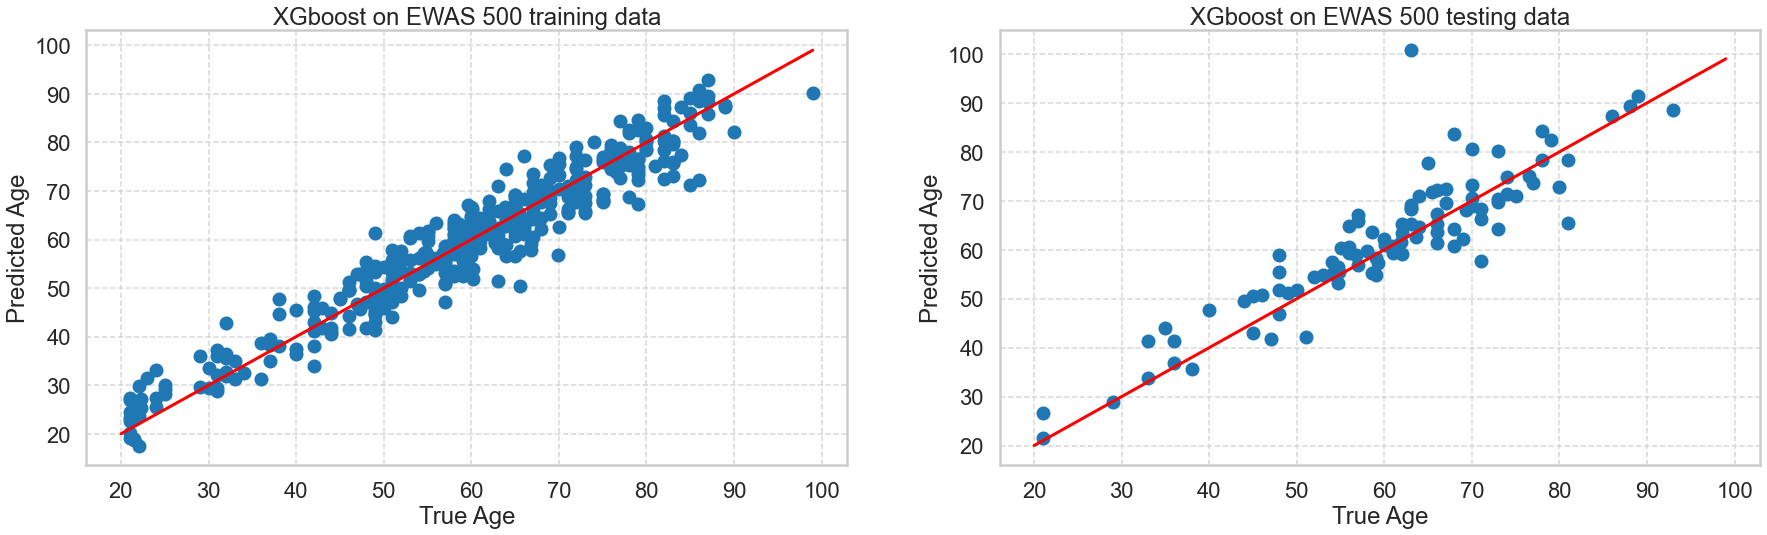

In [111]:
# Making figure of linear top 100 model predicted age vs true age for train and test
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].scatter(y_train3, preds_train3)
ax[0].plot(range(20,100), range(20,100), c='red')
ax[0].set_xlabel('True Age')
ax[0].set_ylabel('Predicted Age')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].set_title('XGboost on EWAS 500 training data')
ax[1].scatter(y_test3, preds_test3)
ax[1].plot(range(20,100), range(20,100), c='red')
ax[1].set_xlabel('True Age')
ax[1].set_ylabel('Predicted Age')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].set_title('XGboost on EWAS 500 testing data')
plt.show()

### Running linear regression with full dataset, all CpGs¶

In [126]:
X4 = df_processed.iloc[:, 5:]
y4 = df_processed.age
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.20)

In [127]:
mod4 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
mod4.fit(X_train4, y_train4)
preds_train4 = mod4.predict(X_train4)
preds_test4 = mod4.predict(X_test4)
r2_score(y_test4, preds_test4)

0.8673405443572787

In [128]:
# Assessing fit, calcualting rms for the train and test data
rms_train4 = (mean_squared_error(y_train4, preds_train4))**0.5
rms_test4 = (mean_squared_error(y_test4, preds_test4))**0.5
print(f'The linear model rms on the training data is {rms_train4} years')
print(f'The linear model rms on the testing data is {rms_test4} years')

The linear model rms on the training data is 4.971458884028238e-13 years
The linear model rms on the testing data is 5.623305523027355 years


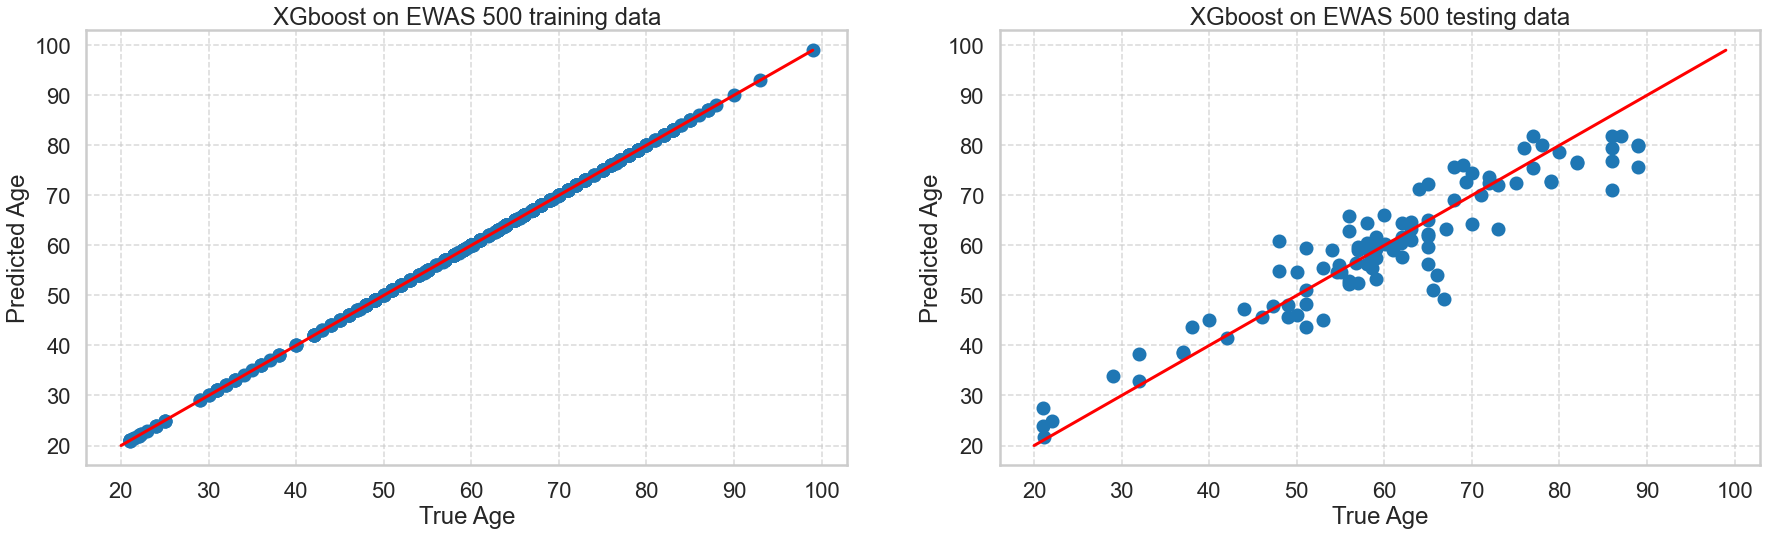

In [129]:
# Making figure of linear top 100 model predicted age vs true age for train and test
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].scatter(y_train4, preds_train4)
ax[0].plot(range(20,100), range(20,100), c='red')
ax[0].set_xlabel('True Age')
ax[0].set_ylabel('Predicted Age')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].set_title('XGboost on EWAS 500 training data')
ax[1].scatter(y_test4, preds_test4)
ax[1].plot(range(20,100), range(20,100), c='red')
ax[1].set_xlabel('True Age')
ax[1].set_ylabel('Predicted Age')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].set_title('XGboost on EWAS 500 testing data')
plt.show()

### PCA Analysis 

In [113]:
## Running PCA on the full dataset
Xp1 = df_processed.iloc[:, 5:]
from sklearn import decomposition
pca1 = decomposition.PCA(n_components=10)
pca1.fit(Xp1)
Xp1_t = pca1.transform(Xp1) # create transformed dataset

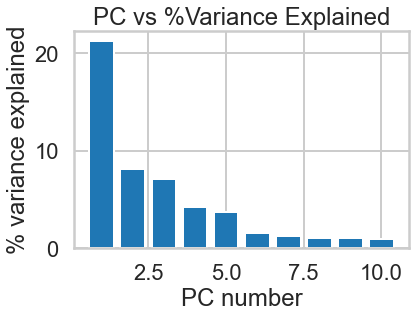

In [114]:
# Plotting % Variance explained by each PC
plt.figure(figsize=(6,4))
plt.bar(range(1,11, 1) , pca1.explained_variance_ratio_*100)
plt.xlabel('PC number')
plt.ylabel('% variance explained')
plt.title('PC vs %Variance Explained')
plt.show()

In [131]:
# Make a dataframe of the PCA results
dfp1_X_t = pd.DataFrame(Xp1_t, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
dfp1_X_t.insert(0, 'age', df_processed.age.values)
dfp1_X_t.insert(1, 'sex', df_processed.sex.values)
dfp1_X_t.insert(2, 'tissue', df_processed.tissue.values)
dfp1_X_t.insert(3, 'platform', df_processed.platform.values)
dfp1_X_t.insert(4, 'project', df_processed.project.values)

In [132]:
dfp1_X_t

,age,sex,tissue,platform,project,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,84.0,F,whole blood,450K,GSE43414,-10.874994,-6.839500,-0.498513,2.656951,2.295835,0.875434,0.126685,-0.725564,-1.565253,-0.421012
1,82.0,F,whole blood,450K,GSE43414,-9.255586,2.075026,1.338540,0.989398,1.935575,1.878282,-3.336948,2.215818,-1.826609,-2.536369
2,80.0,F,whole blood,450K,GSE43414,-8.652303,4.223709,-0.733322,-0.348954,3.361999,1.620297,-2.341307,1.438502,-1.820718,-2.124837
3,88.0,M,whole blood,450K,GSE43414,6.424205,-6.597886,1.649926,1.899419,4.459141,-1.424164,-2.405273,4.279423,-2.721978,-1.895004
4,74.0,F,whole blood,450K,GSE43414,-8.096692,-3.955915,-4.970174,-0.548505,2.220084,-0.452657,0.254504,1.022507,-2.186753,0.409060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,31.0,M,whole blood,450K,GSE53841,9.985486,5.728471,4.434812,0.841025,4.314655,-2.887341,0.710447,-0.966529,1.634212,-0.190928
496,57.0,M,whole blood,450K,GSE54643,4.602482,-7.442712,3.774751,-1.092237,6.216772,-1.899471,-1.929438,2.157653,0.117687,-0.508708
497,57.0,M,whole blood,450K,GSE54643,4.019142,-7.935089,4.891204,-1.275804,6.279585,-1.605268,-1.987149,1.739328,0.638174,-0.417565
498,48.0,M,whole blood,450K,GSE54643,5.693514,-4.369677,3.951577,-2.575933,6.030727,-1.400460,-3.308502,3.347733,0.425246,-1.199900


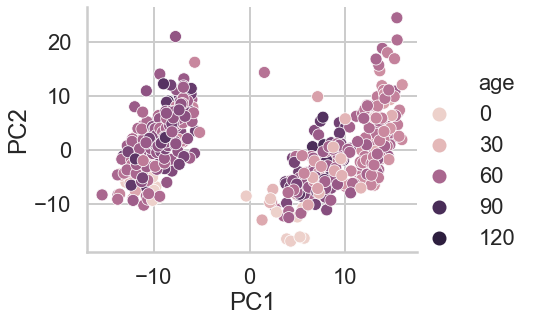

In [134]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='age', data =dfp1_X_t, height=5, aspect= 1.3 )
#plt.ylim(-0.5, 0.5)
#plt.xlim(-1, 1)
plt.show()

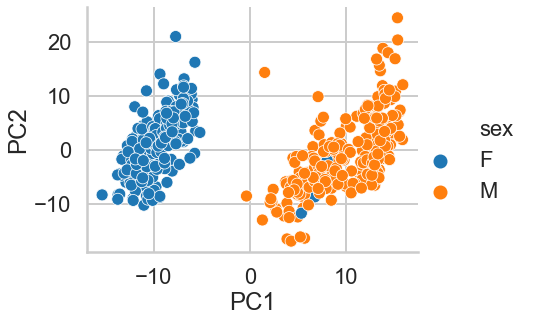

In [135]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='sex', data =dfp1_X_t, height=5, aspect= 1.3 )
#plt.ylim(-0.5, 0.5)
#plt.xlim(-1, 1)
plt.show()

In [136]:
## Runmning PCA on the top 100 importance dataset
Xp2 = df_top100.iloc[:, 1:]
pca2 = decomposition.PCA(n_components=10)
pca2.fit(Xp2)
Xp2_t = pca2.transform(Xp2) # create transformed dataset

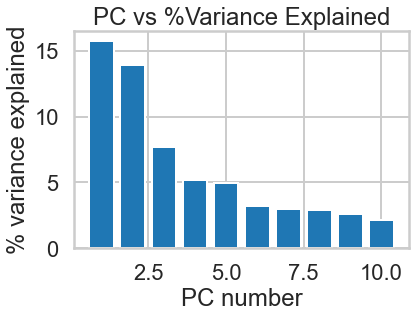

In [137]:
# Plotting % Variance explained by each PC
plt.figure(figsize=(6,4))
plt.bar(range(1,11, 1) , pca2.explained_variance_ratio_*100)
plt.xlabel('PC number')
plt.ylabel('% variance explained')
plt.title('PC vs %Variance Explained')
plt.show()

In [141]:
# Make a dataframe of the PCA results
dfp2_X_t = pd.DataFrame(Xp2_t, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
dfp2_X_t.insert(0, 'age', df_processed.age.values)
dfp2_X_t.insert(1, 'sex', df_processed.sex.values)
dfp2_X_t.insert(2, 'tissue', df_processed.tissue.values)
dfp2_X_t.insert(3, 'platform', df_processed.platform.values)
dfp2_X_t.insert(4, 'project', df_processed.project.values)

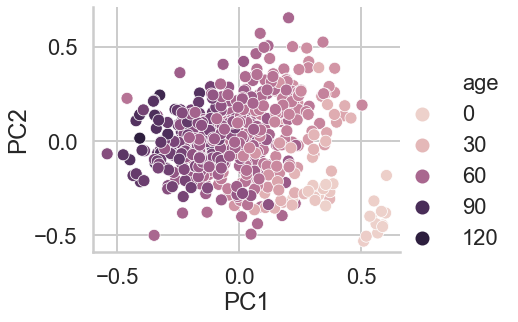

In [142]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='age', data =dfp2_X_t, height=5, aspect= 1.3 )
#plt.ylim(-0.5, 0.5)
#plt.xlim(-1, 1)
plt.show()

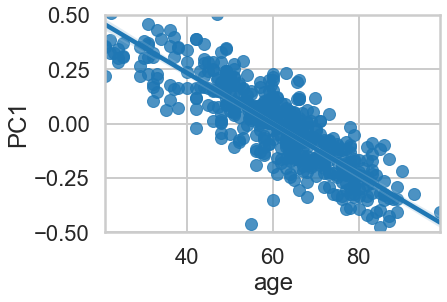

In [143]:
# Make a regression plot with Age and PC1
sns.regplot(x='age', y='PC1', data=dfp2_X_t)
plt.ylim(-0.5, 0.5)
plt.show()

In [144]:
dfp2_X_t.age.corr(df_X_t.PC1)

-0.8641011495352285

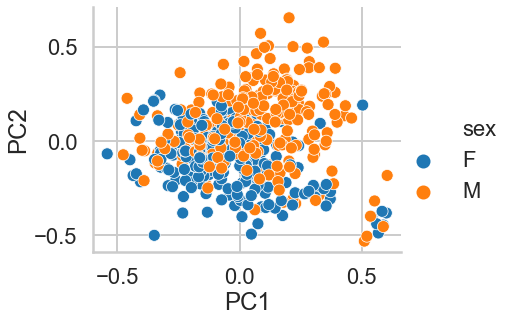

In [145]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='sex', data =dfp2_X_t, height=5, aspect= 1.3 )
#plt.ylim(-0.5, 0.5)
#plt.xlim(-1, 1)
plt.show()

### Runnning Linear regressing with top 100 cpgs just on male samples

In [151]:
df_top100.insert(1, 'sex', df_processed.sex.values)
df_top100.insert(2, 'tissue', df_processed.tissue.values)
df_top100.insert(3, 'platform', df_processed.platform.values)
df_top100.insert(4, 'project', df_processed.project.values)

In [158]:
df_top100_M = df_top100[df_top100.sex == 'M']
df_top100_F = df_top100[df_top100.sex == 'F']

In [159]:
X5 = df_top100_M.iloc[:, 5:]
y5 = df_top100_M.age
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.20)

In [160]:
mod5 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
mod5.fit(X_train5, y_train5)
preds_train5 = mod5.predict(X_train5)
preds_test5 = mod5.predict(X_test5)
r2_score(y_test5, preds_test5)

0.8252546740600932

In [161]:
# Assessing fit, calcualting rms for the train and test data
rms_train5 = (mean_squared_error(y_train5, preds_train5))**0.5
rms_test5 = (mean_squared_error(y_test5, preds_test5))**0.5
print(f'The linear model rms on Male training data is {rms_train5} years')
print(f'The linear model rms on Male testing data is {rms_test5} years')

The linear model rms on Male training data is 3.291473041908045 years
The linear model rms on Male testing data is 7.462096942470963 years


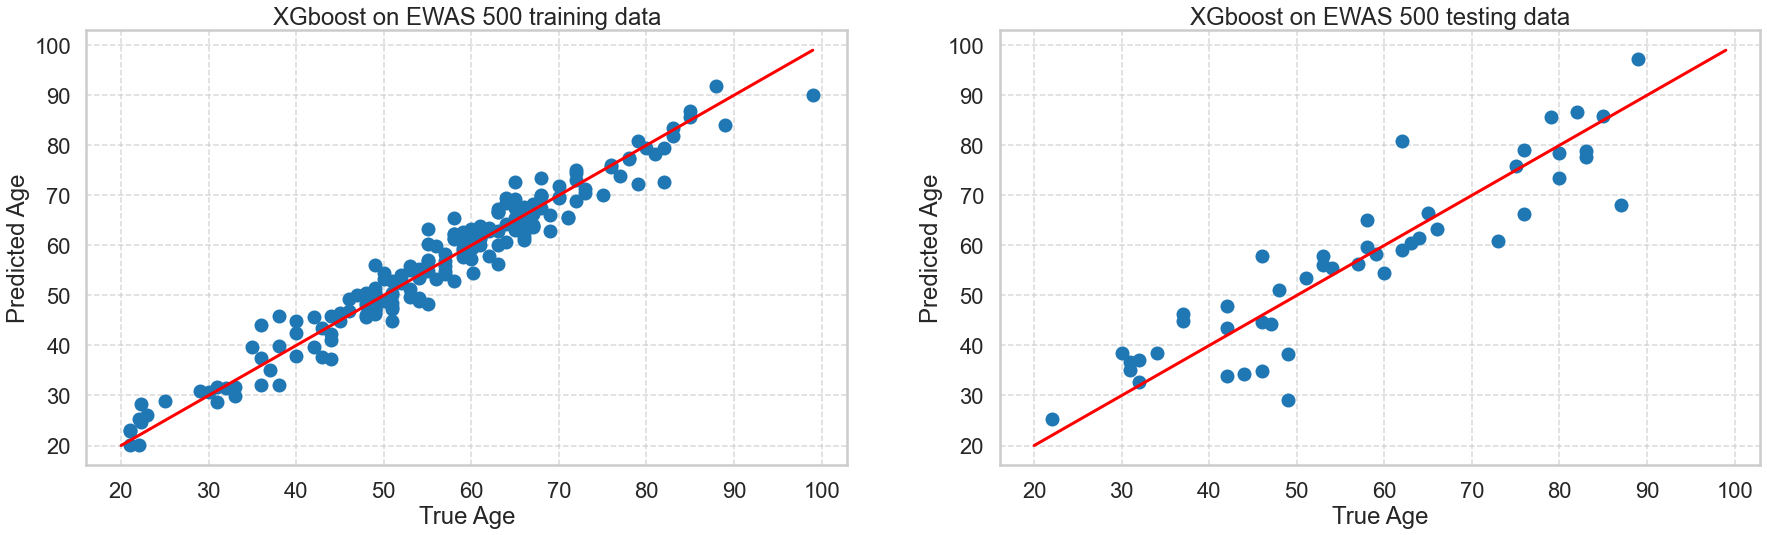

In [162]:
# Making figure of linear top 100 model predicted age vs true age for train and test Male samples
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].scatter(y_train5, preds_train5)
ax[0].plot(range(20,100), range(20,100), c='red')
ax[0].set_xlabel('True Age')
ax[0].set_ylabel('Predicted Age')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].set_title('XGboost on EWAS 500 training data')
ax[1].scatter(y_test5, preds_test5)
ax[1].plot(range(20,100), range(20,100), c='red')
ax[1].set_xlabel('True Age')
ax[1].set_ylabel('Predicted Age')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].set_title('XGboost on EWAS 500 testing data')
plt.show()

### Runnning Linear regressing with top 100 cpgs just on female samples

In [165]:
X6 = df_top100_F.iloc[:, 5:]
y6 = df_top100_F.age
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.20)

In [166]:
mod6 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
mod6.fit(X_train6, y_train6)
preds_train6 = mod6.predict(X_train6)
preds_test6 = mod6.predict(X_test6)
r2_score(y_test6, preds_test6)

0.8509495628663438

In [167]:
# Assessing fit, calcualting rms for the train and test data
rms_train6 = (mean_squared_error(y_train6, preds_train6))**0.5
rms_test6 = (mean_squared_error(y_test6, preds_test6))**0.5
print(f'The linear model rms on Female training data is {rms_train6} years')
print(f'The linear model rms on Female testing data is {rms_test6} years')

The linear model rms on Female training data is 3.478890473155349 years
The linear model rms on Female testing data is 6.321947322756664 years


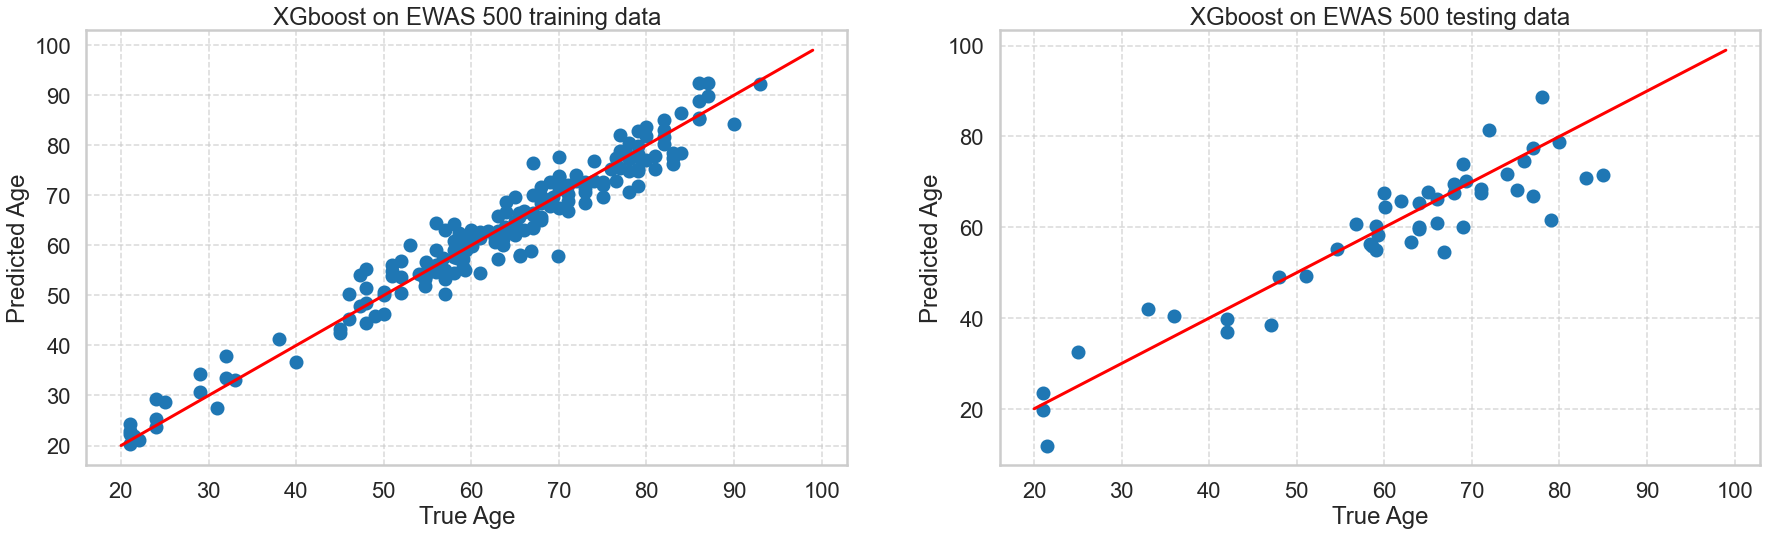

In [168]:
# Making figure of linear top 100 model predicted age vs true age for train and test Female samples
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax[0].scatter(y_train6, preds_train6)
ax[0].plot(range(20,100), range(20,100), c='red')
ax[0].set_xlabel('True Age')
ax[0].set_ylabel('Predicted Age')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].set_title('XGboost on EWAS 500 training data')
ax[1].scatter(y_test6, preds_test6)
ax[1].plot(range(20,100), range(20,100), c='red')
ax[1].set_xlabel('True Age')
ax[1].set_ylabel('Predicted Age')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].set_title('XGboost on EWAS 500 testing data')
plt.show()